In [2]:
import pandas as pd
import numpy as np
import pickle
import itertools
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score


In [3]:
extracted_feature = pd.read_csv('df_features.csv')
print(extracted_feature.shape)
extracted_feature.head()

(40540, 98)


file_name  signal_mean  signal_std  signal_skew  \
0     38359_Rock_music.wav        0.291       0.350        0.553   
1     50194_Rock_music.wav        0.222       0.278        0.990   
2  24275_Hip_hop_music.wav        0.174       0.232        1.326   
3      43654_Pop_music.wav        0.306       0.373        0.607   
4     41609_Rock_music.wav        0.237       0.298        1.004   

   signal_kurtosis  zcr_mean  zcr_std  rmse_mean  rmse_std    tempo  \
0           -0.679     0.261    0.050      0.349     0.030  107.666   
1           -0.015     0.134    0.027      0.276     0.030  135.999   
2            0.876     0.253    0.061      0.223     0.065  143.555   
3           -0.578     0.084    0.043      0.370     0.051  123.047   
4            0.021     0.165    0.062      0.294     0.047  123.047   

          ...          chroma_stft_3_std  chroma_stft_4_std  \
0         ...                      0.280              0.229   
1         ...                      0.252              0.294   
2         ...                      0.333              0.333   
3         ...                      0.209              0.216   
4         ...                      0.255              0.186   

   chroma_stft_5_std  chroma_stft_6_std  chroma_stft_7_std  chroma_stft_8_std  \
0              0.221              0.316              0.195              0.256   
1              0.337              0.289              0.281              0.217   
2              0.229              0.153              0.155              0.252   
3              0.260              0.322              0.299              0.264   
4              0.274              0.241              0.222              0.181   

   chroma_stft_9_std  chroma_stft_10_std  chroma_stft_11_std  \
0              0.248               0.268               0.256   
1              0.257               0.216               0.286   
2              0.273               0.283               0.306   
3              0.193               0.306               0.272   
4              0.246               0.315               0.170   

   chroma_stft_12_std  
0               0.251  
1               0.285  
2               0.303  
3               0.234  
4               0.276  

[5 rows x 98 columns]

In [4]:
label_dict = {'Hip':0,
              'Pop':1,
              'Vocal':2,
              'Rhythm':3,
              'Reggae':4,
              'Rock':5,
              'Techno':6,
             }

# Normalization of the features
scalar = MinMaxScaler()
extracted_feature[extracted_feature.columns[1:]] = scalar.fit_transform(extracted_feature[extracted_feature.columns[1:]])
extracted_feature['label'] = extracted_feature['file_name'].apply(lambda x: label_dict[x[:-4].split('_')[1]])
extracted_feature.head()

file_name  signal_mean  signal_std  signal_skew  \
0     38359_Rock_music.wav     0.313240    0.370763     0.140444   
1     50194_Rock_music.wav     0.238967    0.294492     0.155385   
2  24275_Hip_hop_music.wav     0.187298    0.245763     0.166872   
3      43654_Pop_music.wav     0.329386    0.395127     0.142291   
4     41609_Rock_music.wav     0.255113    0.315678     0.155863   

   signal_kurtosis  zcr_mean   zcr_std  rmse_mean  rmse_std     tempo  ...    \
0         0.002384  0.426471  0.190840   0.370488  0.089820  0.322914  ...     
1         0.003066  0.218954  0.103053   0.292994  0.089820  0.473681  ...     
2         0.003982  0.413399  0.232824   0.236730  0.194611  0.513888  ...     
3         0.002488  0.137255  0.164122   0.392781  0.152695  0.404760  ...     
4         0.003103  0.269608  0.236641   0.312102  0.140719  0.404760  ...     

   chroma_stft_4_std  chroma_stft_5_std  chroma_stft_6_std  chroma_stft_7_std  \
0           0.477083           0.463312           0.691466           0.407098   
1           0.612500           0.706499           0.632385           0.586639   
2           0.693750           0.480084           0.334792           0.323591   
3           0.450000           0.545073           0.704595           0.624217   
4           0.387500           0.574423           0.527352           0.463466   

   chroma_stft_8_std  chroma_stft_9_std  chroma_stft_10_std  \
0           0.535565           0.513458            0.557173   
1           0.453975           0.532091            0.449064   
2           0.527197           0.565217            0.588358   
3           0.552301           0.399586            0.636175   
4           0.378661           0.509317            0.654886   

   chroma_stft_11_std  chroma_stft_12_std  label  
0            0.556522            0.548035      5  
1            0.621739            0.622271      5  
2            0.665217            0.661572      0  
3            0.591304            0.510917      1  
4            0.369565            0.602620      5  

[5 rows x 99 columns]

In [5]:

with open('testset_filenames.txt', 'r') as f:
    test_files = f.readlines()
test_files = [t.strip() for t in test_files]

indices = []
for t in test_files:
    indices.append(extracted_feature[extracted_feature.file_name==t].index[0])
    
extracted_feature_test = extracted_feature.iloc[indices, :]
extracted_feature.drop(labels=indices, inplace=True)


x_train = extracted_feature[extracted_feature.columns[1:-1]]
x_test = extracted_feature_test[extracted_feature.columns[1:-1]]
y_train = extracted_feature['label']
y_test = extracted_feature_test['label']

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

Test Set Accuracy =  0.52
Test Set F-score =  0.47
Confusion matrix, without normalization
[[242  46   8   5  12  18  33]
 [ 65 194  15   5   3  66  35]
 [ 19  22  85   7   2  27   9]
 [ 58  66   9  29  10  35  25]
 [ 43  43   5   1  27   8   5]
 [ 13  45  15   4   1 321  17]
 [ 35  48  10   4   5  62 165]]
CPU times: user 21.3 s, sys: 8.96 s, total: 30.3 s
Wall time: 10 s


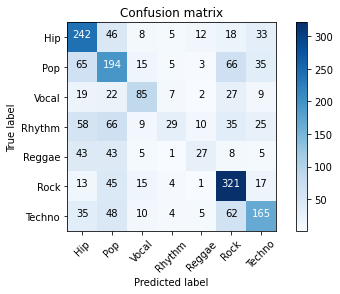

In [7]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)